In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras import backend as K
from keras.layers import Dense, LSTM, TimeDistributed
py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv(filepath_or_buffer="./Data/growth_rate.csv", index_col="date")

In [3]:
# data.head()
# data.tail()
# data.info()

In [4]:
data = data.apply(pd.to_numeric, errors = "coerce")
#data.info()

In [5]:
data['spindx'].replace(0, np.nan, inplace=True)
data['spindx'].fillna(method='ffill', inplace=True)

In [6]:
#reshaping prediction value into value range -1 to 1
from sklearn.preprocessing import MinMaxScaler

# MULTIVARIATE PREDICTION (WITH LOOKBACK AND TIMESTEPS)

In [41]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [42]:
data.columns

Index(['TCMNOM_Y10', 'TCMNOM_Y2', 'DCOILBRENTEU', 'spindx', 'GOLDPMGBD228NLBM',
       'exalus', 'exjpus', 'exukus'],
      dtype='object')

In [43]:
number_of_variables = 8
values = data[['spindx'] + ['TCMNOM_Y2'] + ['TCMNOM_Y10'] + ['DCOILBRENTEU'] + ['GOLDPMGBD228NLBM'] + ['exalus'] + ['exjpus'] + ['exukus']].values
values = values.astype('float32')

In [44]:
values

array([[ 0.00704504,  0.00124224, -0.00560538, ...,  0.00318379,
         0.00479325,  0.00235611],
       [ 0.00710283, -0.01116625, -0.01014656, ...,  0.00137046,
         0.001068  ,  0.00352586],
       [ 0.02463141, -0.02258469, -0.0261959 , ...,  0.01051646,
         0.01920341,  0.02392505],
       ...,
       [ 0.01085129,  0.01056338,  0.00961538, ...,  0.0030581 ,
         0.00088684, -0.00381922],
       [ 0.0105578 , -0.01045296, -0.0031746 , ..., -0.01375496,
        -0.00062024, -0.01495208],
       [-0.00631667,  0.02464789,  0.02547771, ..., -0.00136592,
         0.00265981,  0.00064868]], dtype=float32)

In [45]:
look_back = 10 
time_steps = 1
series_to_supervised(values, look_back, time_steps)
reframed = series_to_supervised(values, look_back, time_steps)
reframed.tail()

,var1(t-10),var2(t-10),var3(t-10),var4(t-10),var5(t-10),var6(t-10),var7(t-10),var8(t-10),var1(t-9),var2(t-9),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
7925,-0.005905,0.000000,0.003175,0.002478,0.008362,-0.003629,-0.001785,-0.001052,0.021496,0.007018,...,-0.007908,0.000128,-0.006560,0.000000,0.000000,0.002067,-0.002472,0.001985,0.007524,0.001411
7926,0.021496,0.007018,0.000000,-0.004697,0.000610,0.000286,0.003041,-0.003160,-0.000253,0.006969,...,0.007524,0.001411,0.015667,0.010676,0.012987,-0.024239,-0.004387,-0.005306,0.002400,0.006019
7927,-0.000253,0.006969,0.009494,-0.007699,-0.001341,0.001357,0.000446,0.005548,-0.014392,-0.006920,...,0.002400,0.006019,0.010851,0.010563,0.009615,-0.011099,-0.008528,0.003058,0.000887,-0.003819
7928,-0.014392,-0.006920,-0.006270,0.004880,-0.004923,0.001711,-0.000891,0.005780,-0.000361,0.017422,...,0.000887,-0.003819,0.010558,-0.010453,-0.003175,-0.047969,0.013334,-0.013755,-0.000620,-0.014952
7929,-0.000361,0.017422,0.009464,0.000996,0.003966,-0.001993,0.003657,0.001306,-0.004299,0.000000,...,-0.000620,-0.014952,-0.006317,0.024648,0.025478,-0.001965,0.000772,-0.001366,0.002660,0.000649


In [46]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed)

/home/tjiang20/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning:

Data with input dtype float32 were all converted to float64 by MinMaxScaler.



In [47]:
# scaled = reframed.values
# scaled

In [48]:
n_train_hours = int(len(scaled) * 0.7)

train = scaled[:n_train_hours, :]
test = scaled[n_train_hours:, :]

In [49]:
# split into input and outputs
train_X, train_y = train[:, :-8], train[:, -8:]
test_X, test_y = test[:, :-8], test[:, -8:]

In [50]:
train_X.shape

(5544, 80)

In [51]:
test_y.shape

(2376, 8)

In [52]:
train_X = train_X.reshape((train_X.shape[0], look_back, 8))
test_X = test_X.reshape((test_X.shape[0], look_back, 8))
#train_y = train_y.reshape((train_y.shape[0], 1, 8))
#test_y = test_y.reshape((test_y.shape[0], 1, 8))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5544, 10, 8) (5544, 8) (2376, 10, 8) (2376, 8)


# Building the Model

In [53]:
train_y

array([[0.62131205, 0.42218273, 0.59106225, ..., 0.43062947, 0.57634975,
        0.29954423],
       [0.67342595, 0.44526875, 0.63867844, ..., 0.42872767, 0.58793787,
        0.30189853],
       [0.64454336, 0.44719828, 0.63863246, ..., 0.42302176, 0.54086263,
        0.23157043],
       ...,
       [0.57945624, 0.44137931, 0.8478768 , ..., 0.40252204, 0.63900111,
        0.27540793],
       [0.68676762, 0.45689655, 0.58566226, ..., 0.44069044, 0.82230419,
        0.39124553],
       [0.68101314, 0.36459296, 0.42372048, ..., 0.31974092, 0.47474783,
        0.23931069]])

In [54]:
# model = Sequential()
# model.add(LSTM(units=100, return_sequences= True, input_shape=(train_X.shape[1],train_X.shape[2])))
# model.add(LSTM(units=100, return_sequences=True))
# model.add(LSTM(units=100, return_sequences=True))
# model.add(LSTM(units=100, return_sequences=True))
# model.add(LSTM(units=100))#, return_sequences= True, input_shape=(train_y.shape[1],8)))

# model.add(Dense(units=8))
# model.summary()

In [55]:
def stock_loss(y_true, y_pred):
    alpha = 100.
    loss = K.switch(K.less(y_true * y_pred, 0), \
        alpha*y_pred**2 - K.sign(y_true)*y_pred + K.abs(y_true), \
        K.abs(y_true - y_pred)
        )
    return K.mean(loss, axis=-1) #+ K.mean(loss, axis =-1)

In [56]:
model = Sequential()

model.add(LSTM(
    input_shape=(train_X.shape[1],train_X.shape[2]),
    return_sequences=True, units=100))
#model.add(Dropout(0.2))
#model.add(LSTM(units=100, return_sequences=True))
#model.add(LSTM(units=100, return_sequences=True))
model.add(LSTM(
    250,
    return_sequences=False))
#model.add(Dropout(0.2))

model.add(Dense(train_X.shape[2], activation='linear'))
#model.add(Activation("linear"))
#opt = Nadam(lr=0.002)
#model.compile(optimizer='adam', loss='mean_squared_error')
model.compile(optimizer='adam', loss=stock_loss)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 100)           43600     
_________________________________________________________________
lstm_4 (LSTM)                (None, 250)               351000    
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 2008      
Total params: 396,608
Trainable params: 396,608
Non-trainable params: 0
_________________________________________________________________


In [57]:
#model.compile(optimizer='adam', loss='mean_squared_error')
n_batch = 150#len(train_X)
history = model.fit(train_X, train_y, epochs=50, batch_size=n_batch, validation_data=(test_X, test_y))

Train on 5544 samples, validate on 2376 samples
Epoch 1/50
5544/5544 [==============================] - 4s 636us/step - loss: 0.0703 - val_loss: 0.0485
Epoch 2/50
5544/5544 [==============================] - 2s 379us/step - loss: 0.0404 - val_loss: 0.0459
Epoch 3/50
5544/5544 [==============================] - 2s 381us/step - loss: 0.0399 - val_loss: 0.0460
Epoch 4/50
5544/5544 [==============================] - 2s 381us/step - loss: 0.0400 - val_loss: 0.0460
Epoch 5/50
5544/5544 [==============================] - 2s 389us/step - loss: 0.0399 - val_loss: 0.0459
Epoch 6/50
5544/5544 [==============================] - 2s 390us/step - loss: 0.0399 - val_loss: 0.0461
Epoch 7/50
5544/5544 [==============================] - 2s 378us/step - loss: 0.0397 - val_loss: 0.0455
Epoch 8/50
5544/5544 [==============================] - 2s 382us/step - loss: 0.0348 - val_loss: 0.0331
Epoch 9/50
5544/5544 [==============================] - 2s 379us/step - loss: 0.0281 - val_loss: 0.0319
Epoch 10/50
5544

In [1]:
# from keras.callbacks import ModelCheckpoint

# weight_path="{}_weights.hdf5".format('8to8market_lstm_growth_rate_model')

# checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
#                              save_best_only=True, mode='min', save_weights_only = False)
# callbacks_list = [checkpoint]

# multi_model = Sequential()
# multi_model.add(LSTM(
#     input_shape=(train_X.shape[1],train_X.shape[2]),
#     return_sequences=True, units=train_X.shape[1]))

# multi_model.add(LSTM(
#     300,
#     return_sequences=True))
# #multi_model.add(TimeDistributed(Dense(number_of_variables)))
# multi_model.compile(loss="mse", optimizer="adam")
# multi_history = multi_model.fit(train_X, train_y, epochs=50, batch_size=150, validation_data=(test_X, test_y),
#                                 verbose=0, shuffle=False)#, callbacks = callbacks_list)




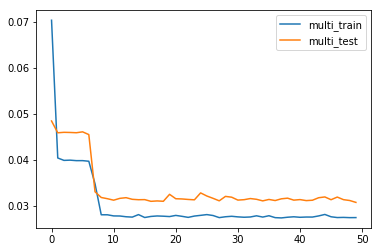

In [58]:
#multi_history = model
pyplot.plot(history.history['loss'], label='multi_train')
pyplot.plot(history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

In [59]:
test_X.shape

(2376, 10, 8)

In [60]:
from keras.models import load_model

#multi_model = load_model("8to8market_lstm_growth_rate_model_weights.hdf5")
multi_model = model
yhat = multi_model.predict(test_X)

In [61]:
test_y[:,0]

array([0.71921599, 0.64484293, 0.59578201, ..., 0.67251477, 0.67159895,
       0.61894353])

In [62]:
yhat[:,0]

array([0.6284678 , 0.6276926 , 0.6265098 , ..., 0.61967516, 0.61922795,
       0.6194349 ], dtype=float32)

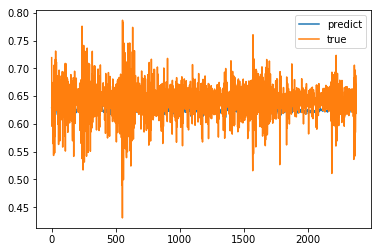

In [63]:
pyplot.plot(yhat[:,0], label='predict')
pyplot.plot(test_y[:,0], label='true')
pyplot.legend()
pyplot.show()

#reshape prediction
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

yhat = yhat.reshape((yhat.shape[0], yhat.shape[2]))

test_X.shape

inv_yhat = concatenate((test_X[:, :], yhat), axis=1)

inv_yhat.shape

#inv_yhat = scaler.inverse_transform(inv_yhat)

inv_yhat[-1]

#inv_yhat[:,-8:].shape

inv_yhat = inv_yhat[:,-8:]

inv_yhat[0]

#reshape actual
test_y = test_y.reshape((test_y.shape[0], test_y.shape[2]))

test_y.shape

inv_y = concatenate((test_X[:, :], test_y), axis=1)

#inv_y = scaler.inverse_transform(inv_y)

inv_y[-1]

#inv_y[:,-8:].shape

inv_y = inv_y[:,-8:]

inv_y[:,0].shape

test_y[:,0].shape

#rmse = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0]))
#print('Test RMSE: %.3f' % rmse)

In [64]:
#reshape prediction
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1] * test_X.shape[2]))

#yhat.shape

#yhat = yhat.reshape((yhat.shape[0], yhat.shape[2]))

#test_X.shape

inv_yhat = concatenate((test_X[:, :], yhat), axis=1)

#inv_yhat.shape

inv_yhat = scaler.inverse_transform(inv_yhat)

#inv_yhat[:,-8:].shape

inv_yhat = inv_yhat[:,-8:]

#inv_yhat.shape

In [65]:
inv_y = concatenate((test_X[:, :], test_y), axis=1)

#inv_y.shape

inv_y = scaler.inverse_transform(inv_y)

inv_y[:,-8:].shape

inv_y = inv_y[:,-8:]

In [66]:
inv_y

array([[ 0.02581761,  0.05434782,  0.06916427, ..., -0.01334825,
         0.01025641, -0.01745314],
       [ 0.00198331, -0.01030928, -0.01617251, ..., -0.01134154,
        -0.00839117, -0.00411184],
       [-0.01373923, -0.05208333, -0.02465753, ...,  0.01122583,
         0.        ,  0.00677126],
       ...,
       [ 0.01085129,  0.01056338,  0.00961538, ...,  0.0030581 ,
         0.00088684, -0.00381922],
       [ 0.0105578 , -0.01045296, -0.0031746 , ..., -0.01375496,
        -0.00062024, -0.01495208],
       [-0.00631667,  0.02464789,  0.02547771, ..., -0.00136592,
         0.00265981,  0.00064868]])

In [67]:
inv_yhat

array([[-0.00326443, -0.00268829,  0.001844  , ...,  0.00032341,
         0.00051631, -0.00064362],
       [-0.00351286, -0.00278911,  0.00188396, ...,  0.000263  ,
         0.00067462, -0.0007074 ],
       [-0.00389191, -0.00353782,  0.00147323, ...,  0.00011715,
         0.00043876, -0.00083147],
       ...,
       [-0.0060822 , -0.00780352, -0.00095937, ..., -0.00061192,
        -0.00026159, -0.00085219],
       [-0.00622552, -0.0079563 , -0.00092627, ..., -0.00064217,
        -0.0001985 , -0.00089294],
       [-0.0061592 , -0.00740397, -0.00066194, ..., -0.00063941,
        -0.0001395 , -0.00089427]])

In [68]:
rmse = sqrt(mean_squared_error(yhat[:,0], test_y[:,0]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.034


In [69]:
rmse = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.011


In [70]:
inv_y[:,0]

array([ 0.02581761,  0.00198331, -0.01373923, ...,  0.01085129,
        0.0105578 , -0.00631667])

In [71]:
inv_yhat[:,0]

array([-0.00326443, -0.00351286, -0.00389191, ..., -0.0060822 ,
       -0.00622552, -0.0061592 ])

In [72]:
test_y[:,0]

array([0.71921599, 0.64484293, 0.59578201, ..., 0.67251477, 0.67159895,
       0.61894353])

In [73]:
yhat[:,0]

array([0.6284678 , 0.6276926 , 0.6265098 , ..., 0.61967516, 0.61922795,
       0.6194349 ], dtype=float32)

In [74]:
# predictDates = data.tail(len(inv_y)).index
# actual_chart = go.Scatter(x=predictDates, y=inv_y[:,0], name= 'Actual Price')
# multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat[:,0], name= 'Multi Predict Price')
# py.iplot([multi_predict_chart, actual_chart])


predictDates = data.tail(len(test_y)).index
actual_chart = go.Scatter(x=predictDates, y=inv_y[:,0], name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat[:,0], name= 'Multi Predict Price')
py.iplot([multi_predict_chart])

In [75]:
py.iplot([multi_predict_chart, actual_chart])